首先，加载数据集并可视化

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
mnist_test = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


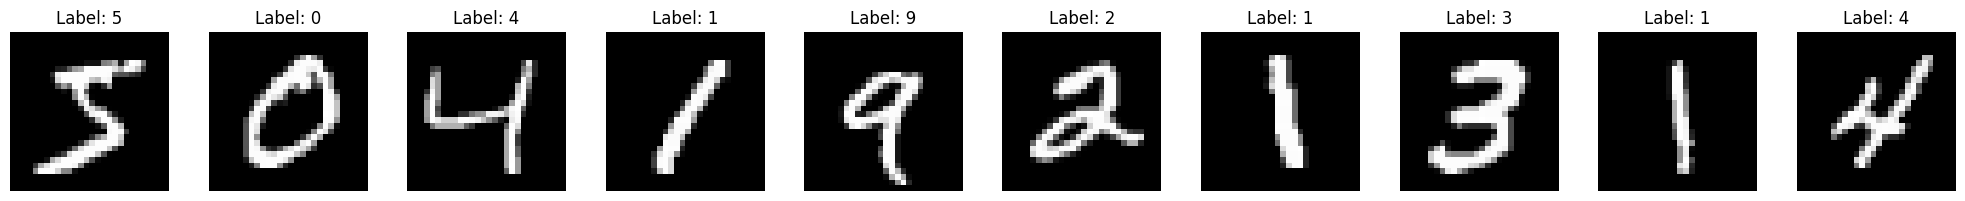

In [6]:
def visualize_mnist(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')  
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


visualize_mnist(mnist_test, num_images=10)

由于维度有784维，较大，需要先进行降维

由于具有标签，考虑使用LDA降维

由于数字具有固有的流行结构，可以考虑使用NPE降维

但是考虑到由于手写数字每个人都有自己的写法，有不同的倾斜程度，不同的弯折角度，因此，LDA效果可能不会太理想，首先考虑使用NPE

降维后形状： (10000, 10)


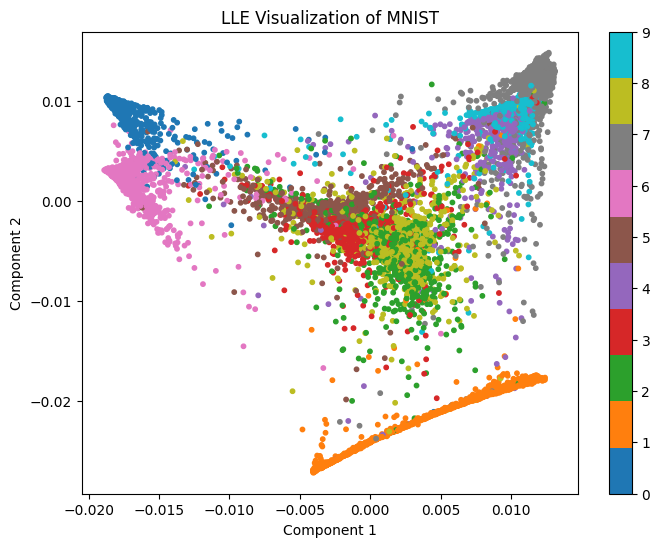

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# 取部分数据以加快降维速度
num_samples = 10000
X = mnist_test.data[:num_samples].reshape(num_samples, -1).numpy()
y = mnist_test.targets[:num_samples].numpy()

# LLE降维到10维
lle = LocallyLinearEmbedding(n_components=10, n_neighbors=10, method='standard', n_jobs=-1)
X_lle = lle.fit_transform(X)

print("降维后形状：", X_lle.shape)
# 可视化前两维
plt.figure(figsize=(8,6))
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=y, cmap='tab10', s=10)
plt.colorbar()
plt.title("LLE Visualization of MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

效果还可以，接下来使用SVM进行分类

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_lle, y, test_size=0.2, random_state=42)

# 训练SVM分类器
svm = SVC(kernel='rbf', C=10) 
svm.fit(X_train, y_train)

# 预测与评估
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("SVM分类准确率：", acc)
print("分类报告：\n", classification_report(y_test, y_pred))

SVM分类准确率： 0.9385
分类报告：
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       207
           1       0.98      1.00      0.99       216
           2       0.96      0.94      0.95       204
           3       0.91      0.88      0.89       192
           4       0.96      0.87      0.91       211
           5       0.92      0.93      0.92       176
           6       0.98      0.97      0.98       220
           7       0.93      0.98      0.95       216
           8       0.93      0.94      0.93       166
           9       0.85      0.89      0.87       192

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



进步一尝试 kernel SVM 查看效果

In [19]:
# 尝试多项式核
svm_poly = SVC(kernel='poly', degree=3, C=10)
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("多项式核SVM分类准确率：", accuracy_score(y_test, y_pred_poly))
print("分类报告：\n", classification_report(y_test, y_pred_poly))

多项式核SVM分类准确率： 0.92
分类报告：
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       207
           1       0.98      0.99      0.99       216
           2       0.79      0.96      0.87       204
           3       0.94      0.81      0.87       192
           4       0.97      0.86      0.91       211
           5       0.89      0.89      0.89       176
           6       0.99      0.96      0.97       220
           7       0.94      0.95      0.94       216
           8       0.92      0.87      0.90       166
           9       0.83      0.89      0.86       192

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [20]:
# 尝试sigmoid核
svm_sigmoid = SVC(kernel='sigmoid', C=10)
svm_sigmoid.fit(X_train, y_train)
y_pred_sigmoid = svm_sigmoid.predict(X_test)
print("Sigmoid核SVM分类准确率：", accuracy_score(y_test, y_pred_sigmoid))
print("分类报告：\n", classification_report(y_test, y_pred_sigmoid))

Sigmoid核SVM分类准确率： 0.7175
分类报告：
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       207
           1       0.48      0.85      0.62       216
           2       0.57      0.27      0.37       204
           3       0.72      0.80      0.76       192
           4       0.59      0.53      0.56       211
           5       0.86      0.79      0.82       176
           6       0.98      0.93      0.95       220
           7       0.81      0.82      0.82       216
           8       0.90      0.78      0.84       166
           9       0.44      0.39      0.41       192

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.71      2000
weighted avg       0.73      0.72      0.71      2000



In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}
grid = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print("最优参数：", grid.best_params_)
print("最优准确率：", grid.best_score_)

最优参数： {'C': 100, 'kernel': 'rbf'}
最优准确率： 0.93612529491578


尝试使用LE降维

降维后形状： (10000, 10)


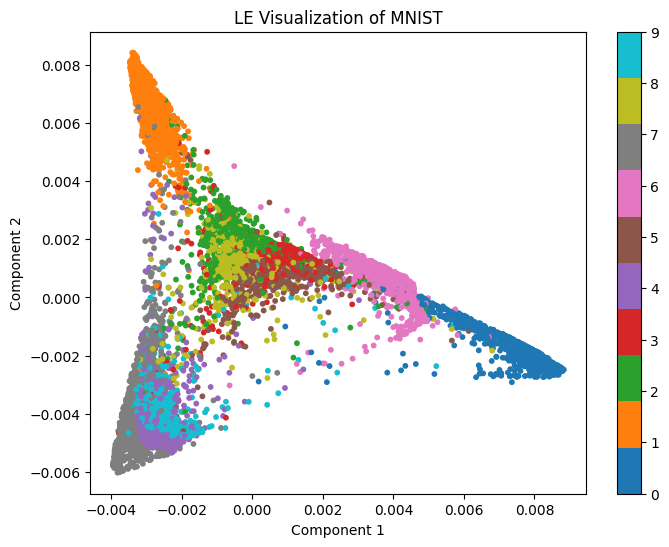

In [26]:
from sklearn.manifold import SpectralEmbedding

# 取部分数据以加快降维速度
num_samples = 10000
X = mnist_test.data[:num_samples].reshape(num_samples, -1).numpy()
y = mnist_test.targets[:num_samples].numpy()

# LE降维到5维
le = SpectralEmbedding(n_components=10, n_neighbors=10, n_jobs=-1)
X_le = le.fit_transform(X)

print("降维后形状：", X_le.shape)
# 可视化前两维
plt.figure(figsize=(8,6))
plt.scatter(X_le[:, 0], X_le[:, 1], c=y, cmap='tab10', s=10)
plt.colorbar()
plt.title("LE Visualization of MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

接下来使用SVM进行分类

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size=0.2, random_state=42)

# 训练SVM分类器
svm = SVC(kernel='rbf', C=10) 
svm.fit(X_train, y_train)

# 预测与评估
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("SVM分类准确率：", acc)
print("分类报告：\n", classification_report(y_test, y_pred))

SVM分类准确率： 0.943
分类报告：
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       207
           1       0.93      1.00      0.96       216
           2       0.97      0.95      0.96       204
           3       0.92      0.90      0.91       192
           4       0.98      0.88      0.93       211
           5       0.95      0.92      0.94       176
           6       0.99      0.98      0.98       220
           7       0.94      0.96      0.95       216
           8       0.95      0.94      0.94       166
           9       0.84      0.90      0.87       192

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



进步一尝试 kernel SVM 查看效果

In [29]:
# 尝试多项式核
svm_poly = SVC(kernel='poly', degree=3, C=10)
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("多项式核SVM分类准确率：", accuracy_score(y_test, y_pred_poly))
print("分类报告：\n", classification_report(y_test, y_pred_poly))

多项式核SVM分类准确率： 0.934
分类报告：
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       207
           1       0.95      0.97      0.96       216
           2       0.94      0.95      0.95       204
           3       0.94      0.89      0.91       192
           4       0.98      0.83      0.90       211
           5       0.93      0.92      0.93       176
           6       0.99      0.97      0.98       220
           7       0.94      0.95      0.94       216
           8       0.90      0.95      0.93       166
           9       0.81      0.91      0.86       192

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.94      0.93      0.93      2000



In [30]:
# 尝试sigmoid核
svm_sigmoid = SVC(kernel='sigmoid', C=10)
svm_sigmoid.fit(X_train, y_train)
y_pred_sigmoid = svm_sigmoid.predict(X_test)
print("Sigmoid核SVM分类准确率：", accuracy_score(y_test, y_pred_sigmoid))
print("分类报告：\n", classification_report(y_test, y_pred_sigmoid))

Sigmoid核SVM分类准确率： 0.816
分类报告：
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       207
           1       0.73      0.94      0.82       216
           2       0.95      0.83      0.89       204
           3       0.77      0.79      0.78       192
           4       0.70      0.70      0.70       211
           5       0.80      0.77      0.79       176
           6       0.93      0.92      0.92       220
           7       0.91      0.88      0.89       216
           8       0.78      0.75      0.76       166
           9       0.60      0.53      0.57       192

    accuracy                           0.82      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.82      0.82      0.81      2000



In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}
grid = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
print("最优参数：", grid.best_params_)
print("最优准确率：", grid.best_score_)

最优参数： {'C': 100, 'kernel': 'rbf'}
最优准确率： 0.9442504983201182
